In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data synthetic data

Load synthetic data created with dyngen

In [2]:
adata = sc.read('../synthetic_datasets/example_bifurcation.h5ad')

# Setup data and model

Setup data for use with LatentVelo

In [3]:
ltv.utils.standard_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 umap=True)

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


This data has a bifurcation in differentation, cells progress from low to high simulation times.

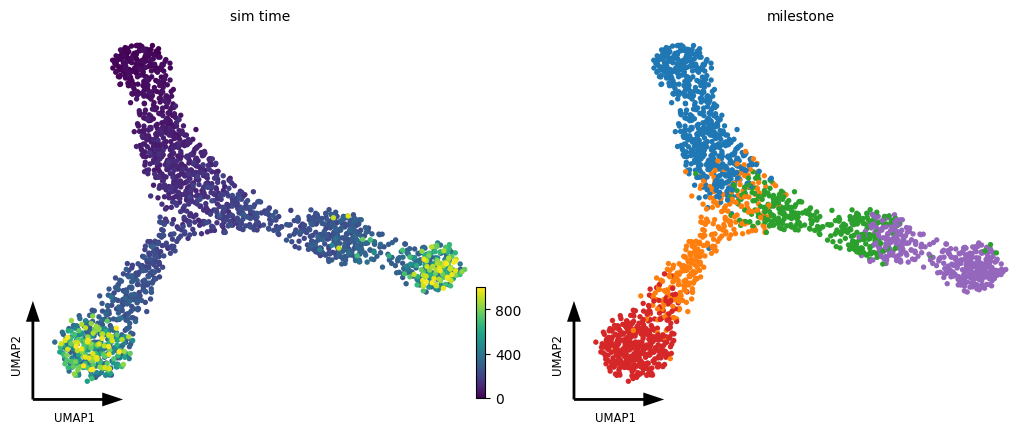

In [4]:
scv.pl.umap(adata, color=['sim_time', 'milestone'], frameon='artist')

We initialize a VAE model with 20 latent dimensions (sizes of both $\mathbf{z}_s$ and $\mathbf{z}_u$), and a $\mathbf{z}_r$ size of 1 and a $\mathbf{h}$ size of 2.

In [5]:
model = ltv.models.VAE(observed=96, latent_dim=20, zr_dim=1, h_dim=2)

# Train the model

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='sythetic_bifurcation_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
30 velocity genes used
epoch 0, full loss 218.935, val loss 90.611, recon MSE 1.540, traj MSE 0.469, reg loss -2.318
epoch 1, full loss 107.230, val loss 57.451, recon MSE 1.356, traj MSE 0.367, reg loss -2.850
epoch 2, full loss 85.681, val loss 37.632, recon MSE 1.224, traj MSE 0.347, reg loss -3.368
epoch 3, full loss 65.663, val loss 18.391, recon MSE 1.090, traj MSE 0.324, reg loss -3.550
epoch 4, full loss 44.978, val loss -1.159, recon MSE 1.021, traj MSE 0.310, reg loss -3.827
epoch 5, full loss 29.723, val loss -20.645, recon MSE 0.859, traj MSE 0.285, reg loss -3.655
epoch 6, full loss 14.511, val loss -40.161, recon MSE 0.711, traj MSE 0.250, reg loss -3.217
epoch 7, full loss 1.503, val loss -58.871, recon MSE 0.585, traj MSE 0.229, reg loss -3.373
epoch 8, full loss -8.148, val loss -76.304, recon MSE 0.490, traj MSE 0.225, reg loss -3.509
epoch 9, full loss -17.346, val loss -90.919, recon MSE 0.427, traj 

The autoencoder loss is the reconstruction error for the autoencoder. The velocity field loss is the reconstruction error for latent trajectories from the ODEs.

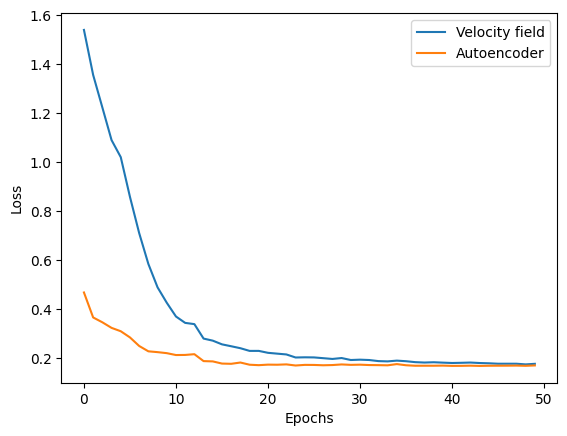

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on umap

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


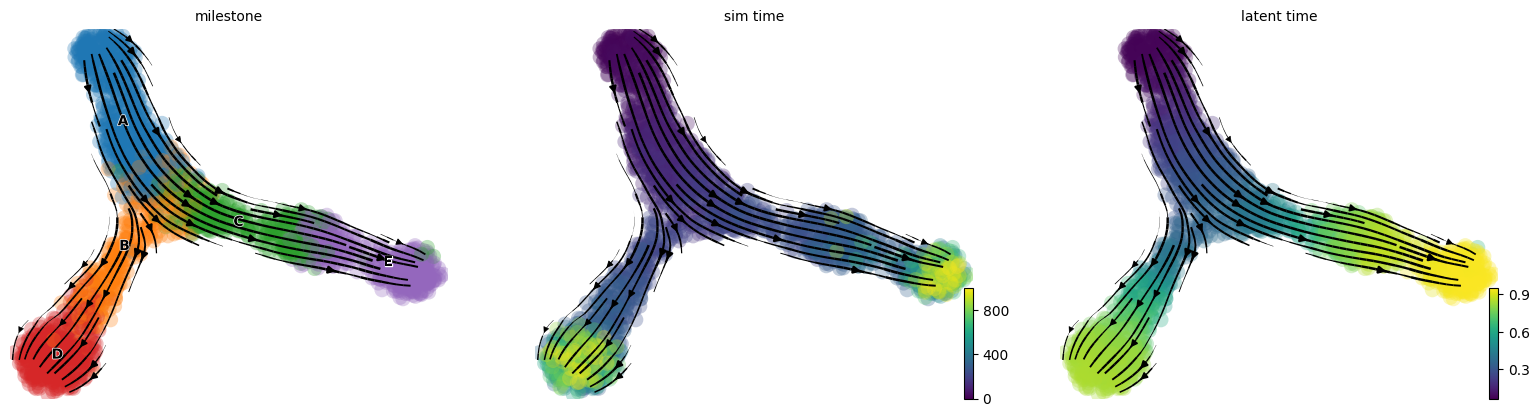

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['milestone', 'sim_time', 'latent_time'])

# Compute CBDir transition scores

Using the milestones provided by dyngen, we can evaluate LatentVelo velocity estimates by using the cross-boundary directedness score

In [11]:
milestone_edges = [
    ('A', 'B'),
    ('A', 'C'), 
    ('B', 'D'),
    ('C', 'E')]

In [12]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
bifurcation_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'milestone', 'spliced_velocity_pca', milestone_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


CBDir scores show that LatentVelo velocity estimates are in the correct directions.

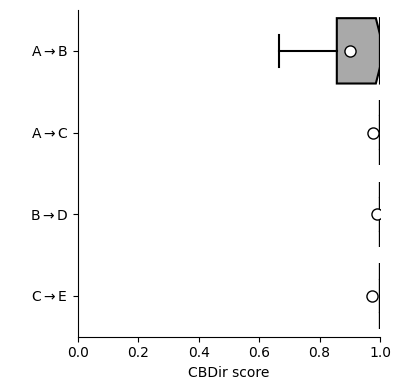

In [13]:
ax=ltv.pl.transition_scores(bifurcation_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Plot $z_r$ scatter

We can visualize the latent regulatory states, which clearly separates the branches.

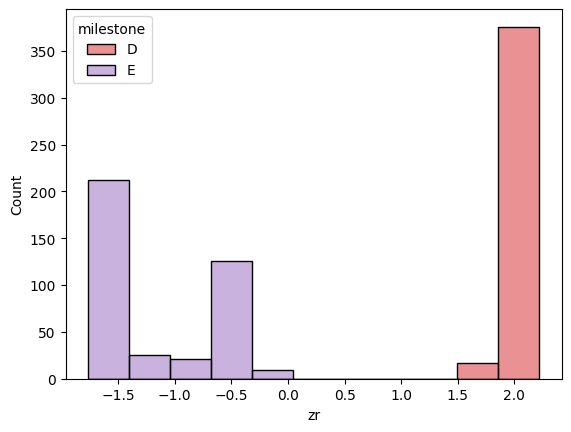

In [14]:
import seaborn as sns
latent_adata.obs['zr'] = latent_adata.obsm['zr'][:,0]
sns.histplot(data=latent_adata[latent_adata.obs.milestone.isin(['D', 'E'])].obs, x='zr',hue='milestone',
               palette=list(latent_adata[latent_adata.obs.milestone.isin(['D', 'E'])].uns['milestone_colors']))
plt.show()

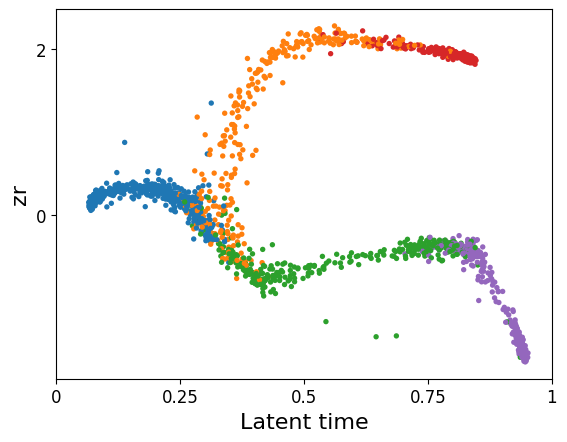

In [15]:
fig,ax=plt.subplots()
scv.pl.scatter(latent_adata, x='latent_time', y = 'zr', color='milestone',
              xlabel='Latent time', ylabel=r'zr', xlim=(0,1), title='',ax=ax, show=False,
              fontsize=16)
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1])
plt.savefig('../diagrams/figures/example_bifurcation_zr_plot_updated.pdf')
plt.show()

# Analyze velocity plots

We can plot the velocity estimates for individual genes.

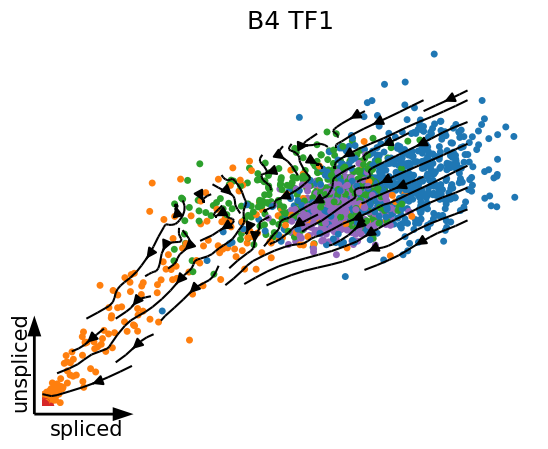

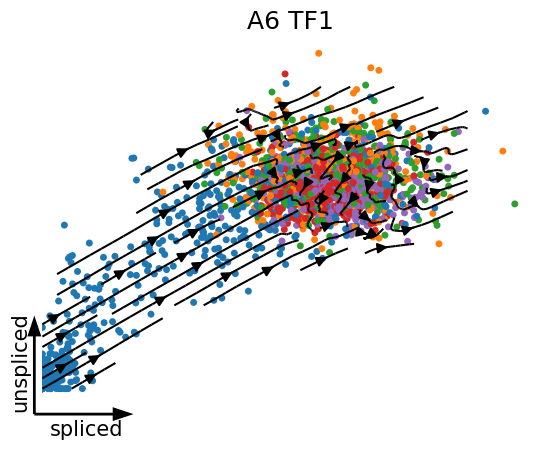

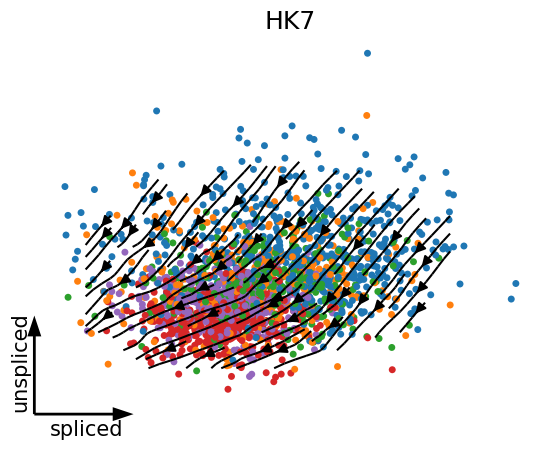

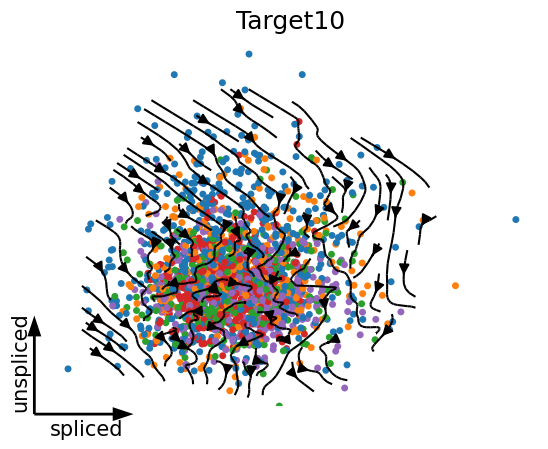

In [16]:
ltv.pl.scatter_stream(adata, 'B4_TF1', cluster_key='milestone')
plt.show()

ltv.pl.scatter_stream(adata, 'A6_TF1', cluster_key='milestone')
plt.show()

ltv.pl.scatter_stream(adata, 'HK7', cluster_key='milestone')
plt.show()

ltv.pl.scatter_stream(adata, 'Target10', cluster_key='milestone')
plt.show()

# Cell trajectories

We can visualize the trajectories of individual cells.

In [17]:
z_traj, times = ltv.cell_trajectories(model, adata)

In [18]:
from umap import UMAP
umap = UMAP(n_components=2, n_neighbors=30, min_dist=1, random_state=3).fit(latent_adata.X)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap_latent', embedded velocity vectors (adata.obsm)


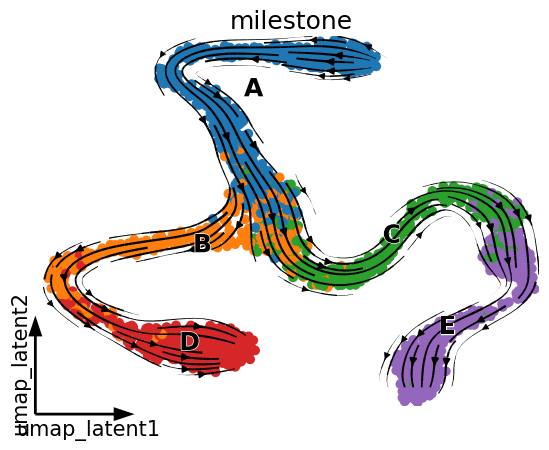

In [19]:
latent_adata.obsm['X_umap_latent'] = umap.transform(latent_adata.X)
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['milestone'], alpha=1, size=200,
                frameon='artist')

saving figure to file ../diagrams/figures/example_bifurcation_latent_umap_updated.png


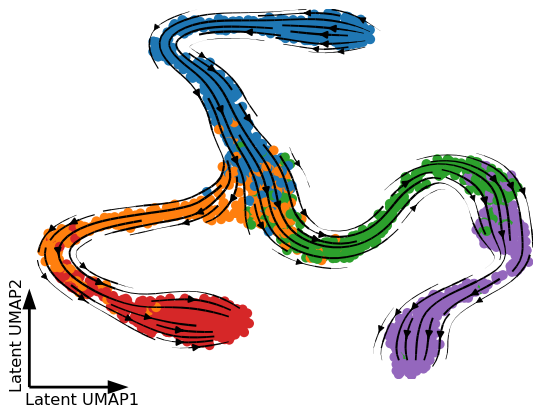

In [20]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['milestone'], alpha=1, size=200,
                                frameon='artist', xlabel='Latent UMAP1', 
                                ylabel='Latent UMAP2',fontsize=14, title='', legend_loc='none',
                                save='../diagrams/figures/example_bifurcation_latent_umap_updated.png')

In [21]:
print('D cell:', np.where((latent_adata.obs.milestone =='D') & (latent_adata.obs.latent_time > 0.8))[0][0])
print('E cell:', np.where((latent_adata.obs.milestone =='E') & (latent_adata.obs.latent_time > 0.9))[0][0])

D cell: 0
E cell: 8


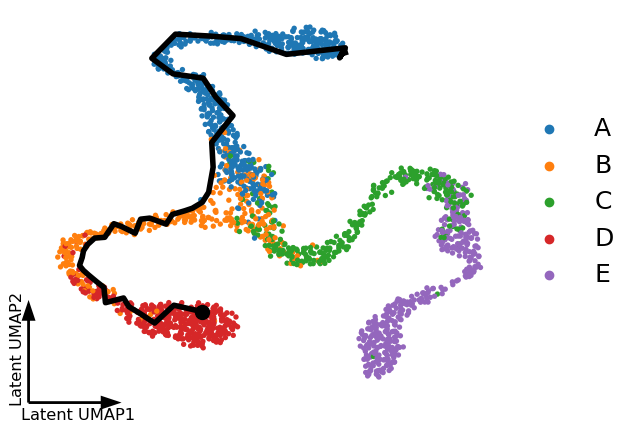

In [22]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(6,5))
cell = 0

z_traj_pca = umap.transform(z_traj[cell,times[cell,:,0]<=latent_adata.obs['latent_time'][cell],:20].detach().cpu().numpy())
plt.plot(z_traj_pca[:,0], z_traj_pca[:,1], color='k', linewidth=4)
plt.plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color='k', linewidth=4, marker='o', markersize=10)

scv.pl.scatter(latent_adata, 'umap_latent', ax=ax, color='milestone', frameon='artist',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=14, title='', legend_loc='right')
plt.savefig('../diagrams/figures/example_bifurcation_latent_trajectory_D.png')
plt.show()

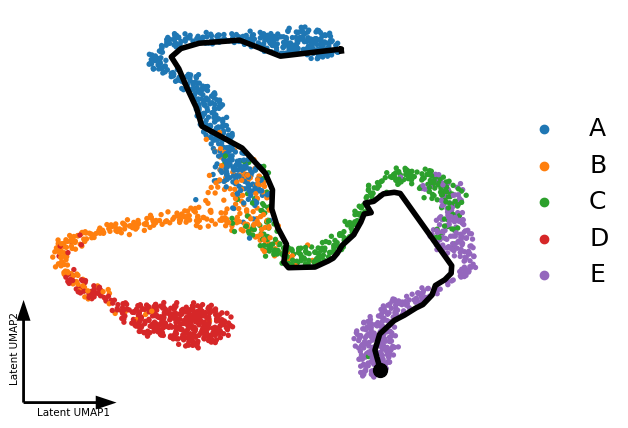

In [23]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(6,5))
cell = 8
z_traj_pca = umap.transform(z_traj[cell,times[cell,:,0]<=latent_adata.obs['latent_time'][cell],:20].detach().cpu().numpy())
plt.plot(z_traj_pca[:,0], z_traj_pca[:,1], color='k', linewidth=4)
plt.plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color='k', linewidth=4, marker='o', markersize=10)

scv.pl.scatter(latent_adata, 'umap_latent', ax=ax, color='milestone', frameon='artist',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=9, title='', legend_loc='right')
plt.savefig('../diagrams/figures/example_bifurcation_latent_trajectory_E.png')
plt.show()